##Classification Task

###Import Libraries

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, average_precision_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt


###Load and Preprocess Datasets and Feature Mapping

In [ ]:
# Load the PROMOPROMS dataset
data_promoproms = pd.read_csv('/content/drive/MyDrive/datasets/PROMOPROMS_FINAL.csv')
data_promoproms['Date'] = pd.to_datetime(data_promoproms['Date'])

# Impute missing values in PROMOPROMS
missing_columns = data_promoproms.columns[data_promoproms.isnull().any()]
for column in missing_columns:
    if data_promoproms[column].dtype == 'object':
        data_promoproms[column].fillna(data_promoproms[column].mode()[0], inplace=True)
    else:
        data_promoproms[column].fillna(data_promoproms[column].mean(), inplace=True)

# Sort data by patient ID and date
data_promoproms = data_promoproms.sort_values(by=['ID', 'Date'])

# Calculate EDSS change over a 1-year period with 4-month intervals
data_promoproms['EDSS_change'] = data_promoproms.groupby('ID')['EDSS TOT 2'].diff(periods=3).fillna(0)

# Create a binary target variable: same (0) or worse (1)
data_promoproms['EDSS_status'] = (data_promoproms['EDSS_change'] > 0).astype(int)

# Rename PROMOPROMS features according to the mapping
feature_mapping = {
    'AGE_sess': 'Age',
    'EDSS 000': 'EDSS_Visual',
    'EDSS 001': 'EDSS_Brainstem',
    'EDSS 002': 'EDSS_Pyramidal',
    'EDSS 003': 'EDSS_Cerebellar',
    'EDSS 004': 'EDSS_Sensory',
    'EDSS 005': 'EDSS_Bowel',
    'EDSS 006': 'EDSS_Mental',
    'EDSS 007': 'EDSS_Walking',
    'EDSS TOT 2': 'EDSS_TOT',
    'MOCA TOT': 'MoCa',
    'SDMT TOT': 'SDMT',
    'MFIS 001': 'MFIS_1',
    'MFIS 002': 'MFIS_2',
    'MFIS 003': 'MFIS_3',
    'MFIS 004': 'MFIS_4',
    'MFIS 005': 'MFIS_5',
    'MFIS 006': 'MFIS_6',
    'MFIS 007': 'MFIS_7',
    'MFIS 008': 'MFIS_8',
    'MFIS 009': 'MFIS_9',
    'MFIS 010': 'MFIS_10',
    'MFIS 011': 'MFIS_11',
    'MFIS 012': 'MFIS_12',
    'MFIS 013': 'MFIS_13',
    'MFIS 014': 'MFIS_14',
    'MFIS 015': 'MFIS_15',
    'MFIS 016': 'MFIS_16',
    'MFIS 017': 'MFIS_17',
    'MFIS 018': 'MFIS_18',
    'MFIS 019': 'MFIS_19',
    'MFIS 020': 'MFIS_20',
    'MFIS 021': 'MFIS_21',
    'MFIS TOT': 'MFIS TOT',
    'OAB-Q001': 'OAB-Q_1',
    'OAB-Q002': 'OAB-Q_2',
    'OAB-Q003': 'OAB-Q_3',
    'OAB-Q004': 'OAB-Q_4',
    'OAB-Q005': 'OAB-Q_5',
    'OAB-Q006': 'OAB-Q_6',
    'OAB-Q007': 'OAB-Q_7',
    'OAB-Q008': 'OAB-Q_8',
    'OAB-QTOT': 'OAB-Q TOT',
    'RELAPS': 'Last relapse',
    'GEND_F': 'Gender_F',
    'GEND_M': 'Gender_M'
}
data_promoproms.rename(columns=feature_mapping, inplace=True)

# Select only the mapped features
selected_features_promoproms = list(feature_mapping.values())
X_promoproms = data_promoproms[selected_features_promoproms]
y_promoproms = data_promoproms['EDSS_status']

# Standardize PROMOPROMS features
scaler = StandardScaler()
X_promoproms_scaled = scaler.fit_transform(X_promoproms)

# Load the ALAMEDA dataset
data_alameda = pd.read_csv('/content/drive/MyDrive/datasets/Updated_ALAMEDA_FISM_final_with_numerical_IDs.csv')
data_alameda['Timepoint'] = pd.to_datetime(data_alameda['Timepoint'])

# Apply one-hot encoding to the 'Gender' column with explicit naming
encoder = OneHotEncoder(sparse_output=False)
gender_encoded = encoder.fit_transform(data_alameda[['Gender']])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=['Gender_F', 'Gender_M'])

# Drop the original 'Gender' column and concatenate the encoded dataframe
data_alameda = pd.concat([data_alameda.drop(columns=['Gender']), gender_encoded_df], axis=1)

# Impute missing values if any
missing_columns_alameda = data_alameda.columns[data_alameda.isnull().any()]
for column in missing_columns_alameda:
    if data_alameda[column].dtype == 'object':
        data_alameda[column].fillna(data_alameda[column].mode()[0], inplace=True)
    else:
        data_alameda[column].fillna(data_alameda[column].mean(), inplace=True)
# Ensure both datasets have the same features
selected_features_alameda = [feature for feature in selected_features_promoproms if feature in data_alameda.columns]

# Inform if any columns from PROMOPROMS are missing in ALAMEDA
missing_features = list(set(selected_features_promoproms) - set(selected_features_alameda))
if missing_features:
    print(f"Warning: The following features are missing in the ALAMEDA dataset and will be ignored: {missing_features}")

# Select the available features for ALAMEDA
X_alameda = data_alameda[selected_features_alameda]

# Define the target variable for ALAMEDA as a binary variable based on the median of EDSS_TOT
y_alameda = (data_alameda['EDSS_TOT'] > data_alameda['EDSS_TOT'].median()).astype(int)

# Standardize the ALAMEDA features using the same scaler fitted on PROMOPROMS data
X_alameda_scaled = scaler.transform(X_alameda)


###Combine the Datasets and Address Class Imbalance

In [ ]:
# Combine the datasets
X_combined = np.vstack([X_promoproms_scaled, X_alameda_scaled])
y_combined = np.hstack([y_promoproms, y_alameda])

# Perform SMOTE on the combined dataset to address class imbalance
smote = SMOTE(random_state=42)
X_resampled_combined, y_resampled_combined = smote.fit_resample(X_combined, y_combined)


###Initialize the Models

In [ ]:
# Initialize models
logistic_model = LogisticRegression(max_iter=2000, random_state=42, C=0.5, solver='saga', penalty='l1')
gb_classifier = GradientBoostingClassifier(random_state=42, n_iter_no_change=10, learning_rate=0.01, max_depth=3, min_samples_split=10, subsample=0.8, n_estimators=2000, min_samples_leaf=5, max_features='sqrt')
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50,), max_iter=2000, random_state=42, alpha=0.1, learning_rate_init=0.001, solver='adam', early_stopping=True, validation_fraction=0.1)


###Define Function for Cross-Validation Metrics

In [ ]:
# Define a function to perform 5-fold cross-validation and collect metrics
def cross_val_metrics(model, X, y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_losses = cross_val_score(model, X, y, cv=cv, scoring='neg_log_loss')
    accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    precisions = cross_val_score(model, X, y, cv=cv, scoring='precision')
    recalls = cross_val_score(model, X, y, cv=cv, scoring='recall')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    pr_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='average_precision')

    return {
        'Validation Loss': -log_losses.mean(),
        'Accuracy': accuracies.mean(),
        'AU PRC': pr_auc_scores.mean(),
        'F1 Score': f1_scores.mean(),
        'Precision': precisions.mean(),
        'Recall': recalls.mean()
    }


###Collect and Compare Model Metrics

In [ ]:
# Collect metrics for each model
logistic_metrics = cross_val_metrics(logistic_model, X_resampled_combined, y_resampled_combined)
gb_metrics = cross_val_metrics(gb_classifier, X_resampled_combined, y_resampled_combined)
mlp_metrics = cross_val_metrics(mlp_classifier, X_resampled_combined, y_resampled_combined)

# Store metrics in a dictionary for easier comparison
metrics_dict = {
    'Logistic Regression': logistic_metrics,
    'Gradient Boosting': gb_metrics,
    'MLP Classifier': mlp_metrics
}

# Convert the dictionary to a DataFrame for easier visualization
metrics_df = pd.DataFrame(metrics_dict).T

# Print metrics for the models
print("Cross-Validation Metrics on Combined Dataset:")
print(metrics_df)


Cross-Validation Metrics on Combined Dataset:
                     Validation Loss  Accuracy    AU PRC  F1 Score  Precision  \
Logistic Regression         0.541597  0.724196  0.785576  0.731549   0.713039   
Gradient Boosting           0.196187  0.935093  0.981798  0.932938   0.962804   
MLP Classifier              0.423533  0.811723  0.876433  0.817731   0.789260   

                       Recall  
Logistic Regression  0.752340  
Gradient Boosting    0.905200  
MLP Classifier       0.849009  


###Plot Model Performance Metrics

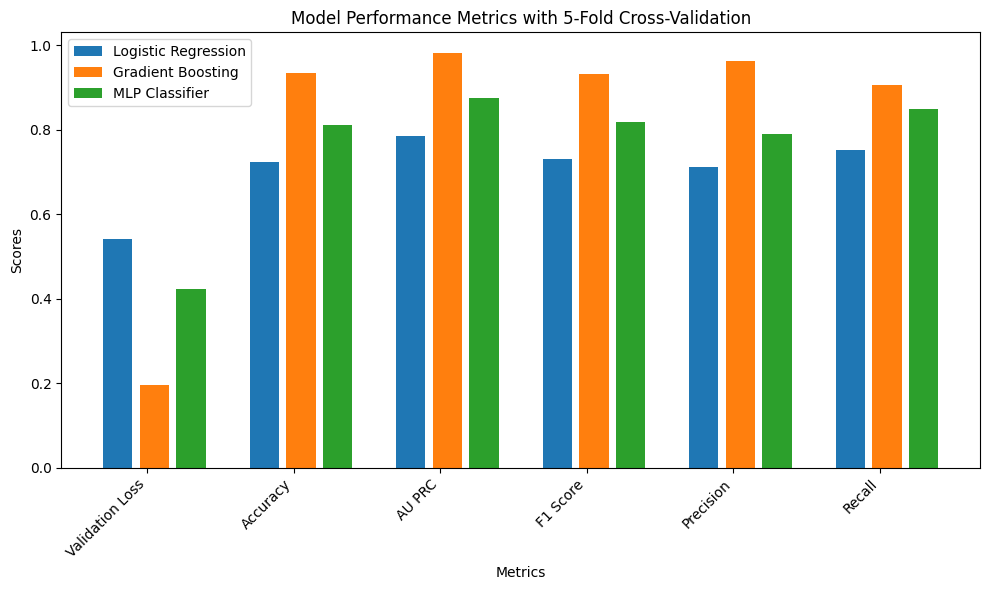

In [ ]:
# Plotting the metrics
metrics = metrics_df.columns
models = metrics_df.index

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting metrics
for i, model in enumerate(models):
    ax.bar(x + i*(width + 0.05), metrics_df.loc[model], width, label=model)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics with 5-Fold Cross-Validation')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()
